# 어제 오른 내 주식, 과연 내일은?

## 삼성전자

In [1]:
# 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os

## STEP 1 : 시계열 데이터 준비

In [2]:
# data load
dataset_filepath = './data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


In [3]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

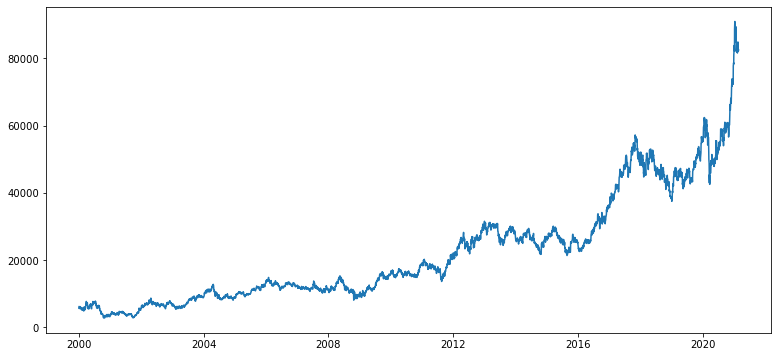

In [4]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

## STEP 2 : 각종 전처리 수행

In [5]:
# 결측치 확인
ts[ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [6]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


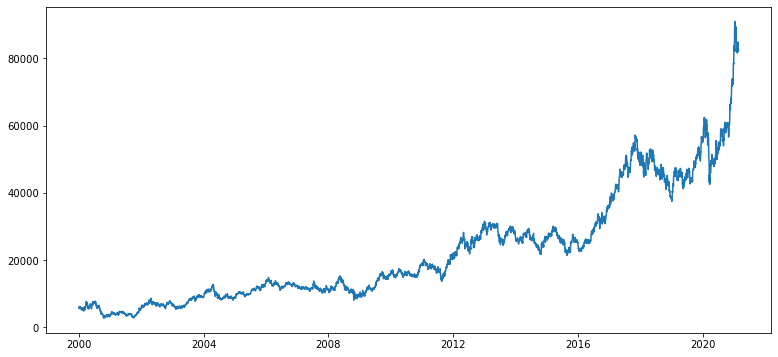

In [7]:
plt.plot(ts)

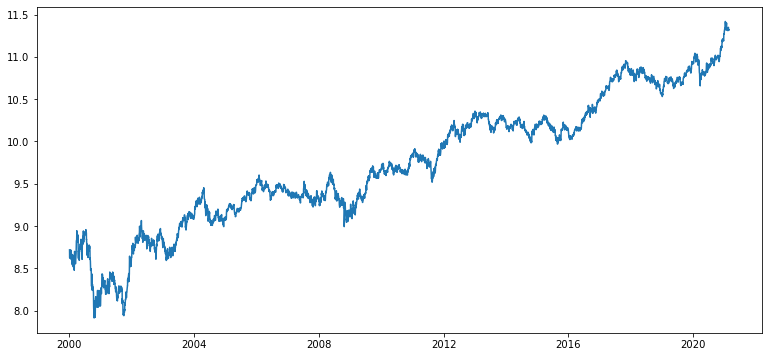

In [8]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [9]:
# adfuller method를 이용하여 Augmented Dickey-Fuller Test 수행
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
# 일정 구간 내 통계치(Rolling Statistics)를 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

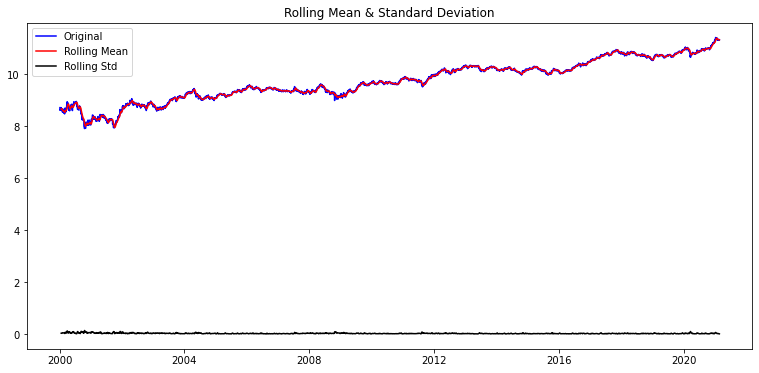

In [11]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [12]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.318364
p-value                           0.922863
#Lags Used                        4.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


- p-value가 0.05 이상이므로 Stationary하지 않은 데이터라고 할 수 있다.

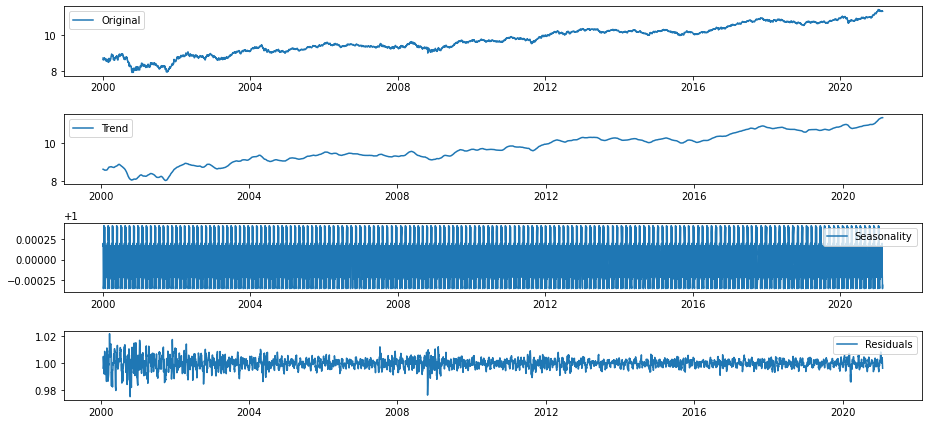

In [13]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [14]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.761198e+01
p-value                        3.875617e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.251000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


## STEP 4 : train, test dataset 생성

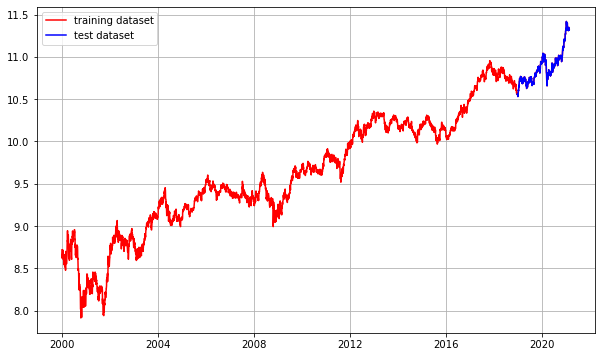

In [15]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

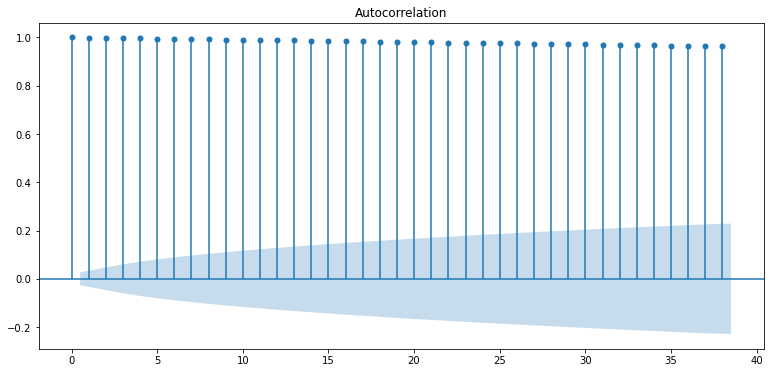

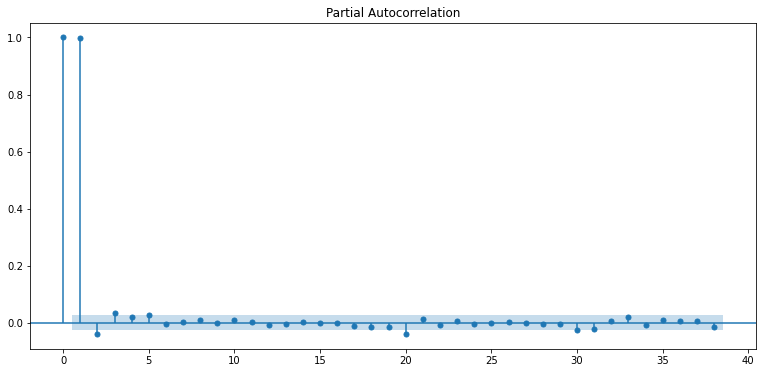

In [16]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.096012
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


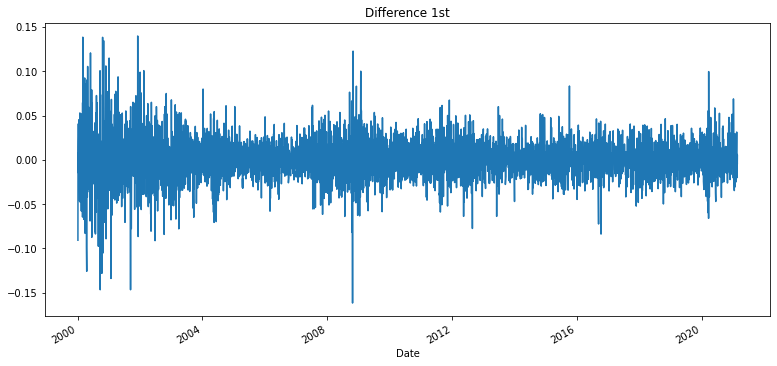

In [17]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.815300
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5279.000000
Critical Value (1%)              -3.431589
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


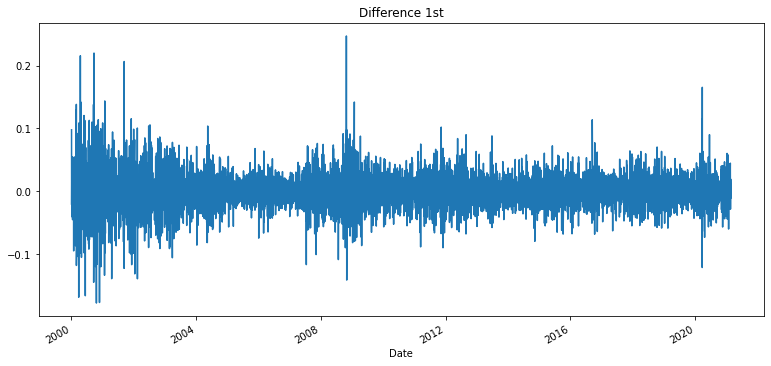

In [18]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [19]:
# ARIMA 모델 설계
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4782
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11269.113
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 23 Feb 2021   AIC                         -22532.227
Time:                        16:53:45   BIC                         -22512.809
Sample:                             1   HQIC                        -22525.406
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.113      0.266      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

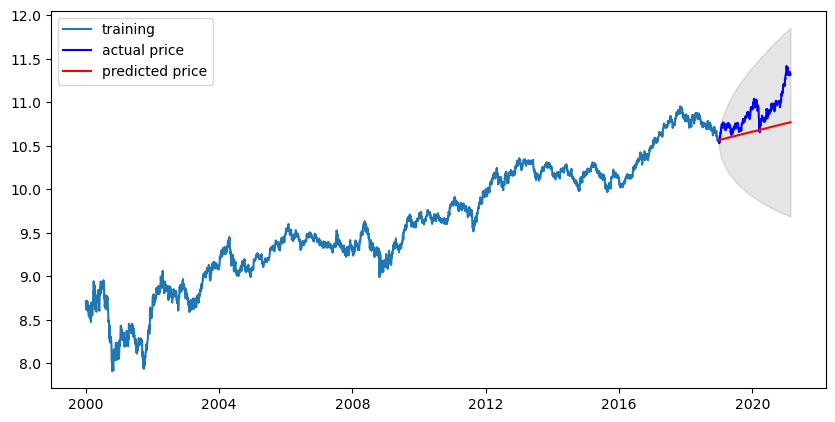

In [20]:
# 모델 예측
# Forecast : 결과가 fc에 담김
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [21]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  204036191.7860741
MAE:  10948.743208869895
RMSE:  14284.123766828476
MAPE: 18.16%


- 추세는 어느 정도 맞는 것 같지만 정확도가 생각보다 떨어지는 것 같다.
- 데이터의 기간을 줄이면 정확도가 올라간다고 하여 1년을 기준으로 다시 시도해보았다.

## STEP 1 : 시계열 데이터 준비

In [22]:
# data load
dataset_filepath = './data/005930.KS_1years.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-24,57400.0,58100.0,56800.0,56800.0,54300.218750,25627537
2020-02-25,56200.0,58000.0,56200.0,57900.0,55351.808594,23885408
2020-02-26,56000.0,57000.0,56000.0,56500.0,54013.425781,25483102
2020-02-27,56300.0,56900.0,55500.0,55900.0,53439.832031,23209541
2020-02-28,55000.0,55500.0,54200.0,54200.0,51814.648438,30054227


In [23]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
Name: Close, dtype: float64

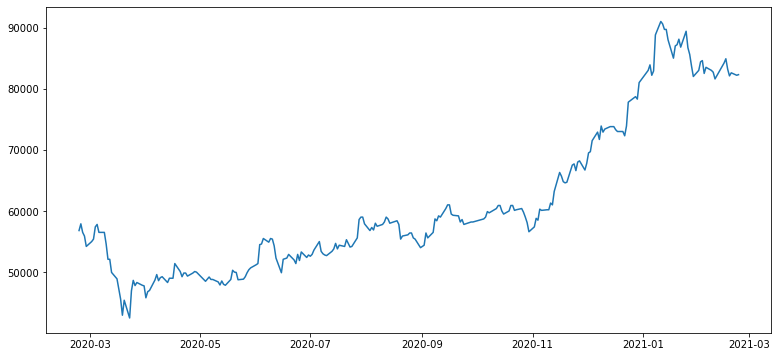

In [24]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

## STEP 2 : 각종 전처리 수행

In [25]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [26]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


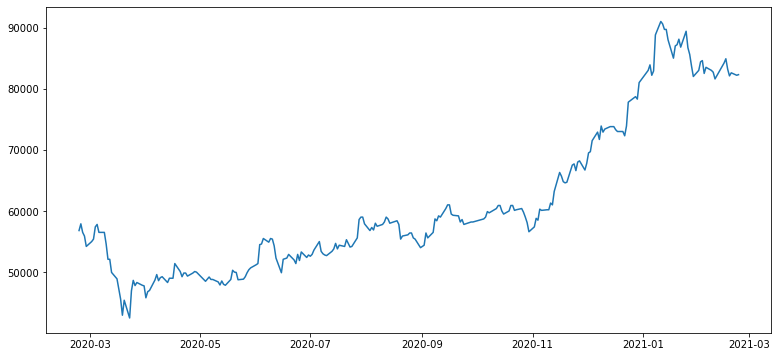

In [27]:
plt.plot(ts)

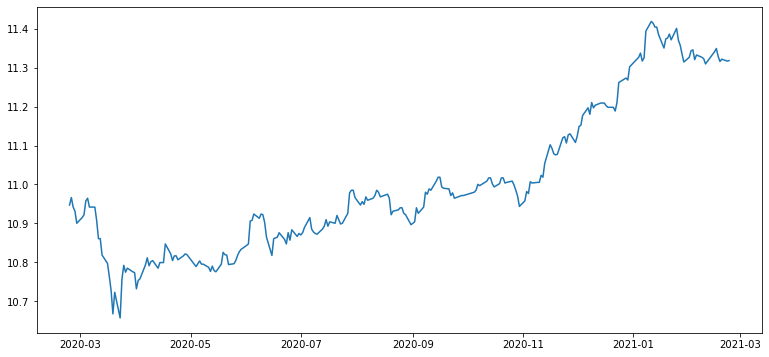

In [28]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [29]:
# adfuller method를 이용하여 Augmented Dickey-Fuller Test 수행
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [30]:
# 일정 구간 내 통계치(Rolling Statistics)를 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

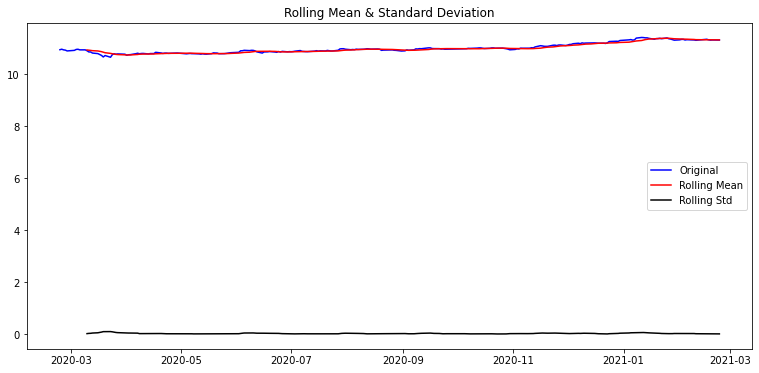

In [31]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [32]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.082538
p-value                          0.951150
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- p-value가 0.05 이상이므로 Stationary하지 않은 데이터라고 할 수 있다.

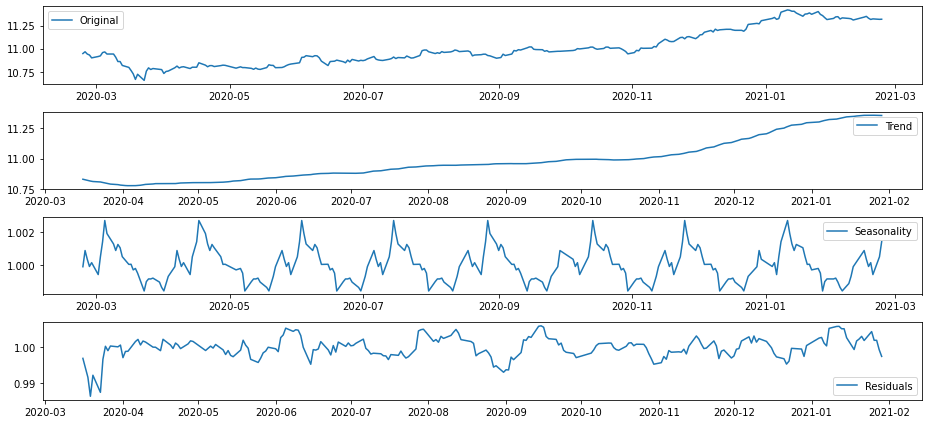

In [33]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.901171e+00
p-value                        2.775821e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


## STEP 4 : train, test dataset 생성

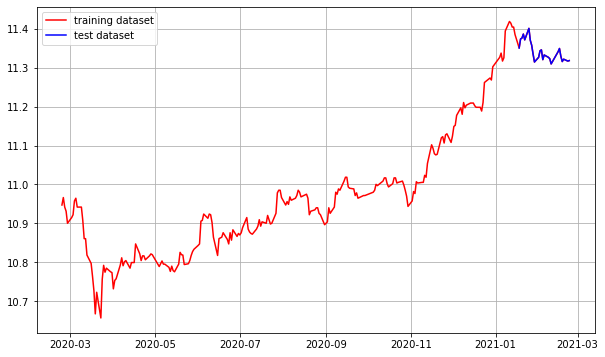

In [35]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

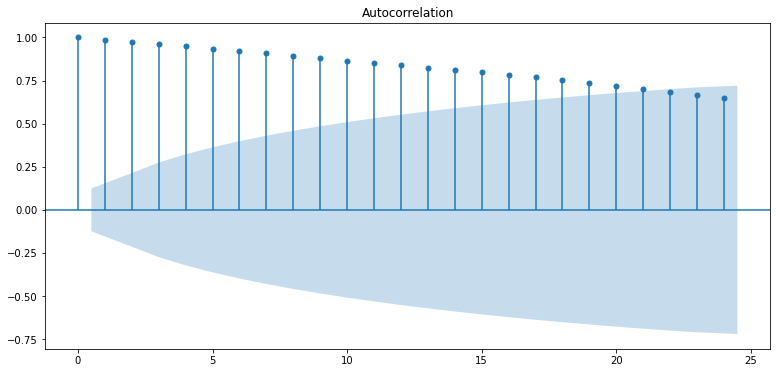

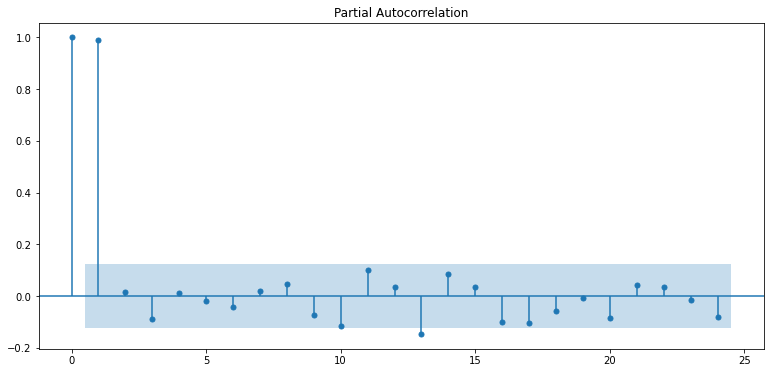

In [36]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.604733e+01
p-value                        5.825446e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


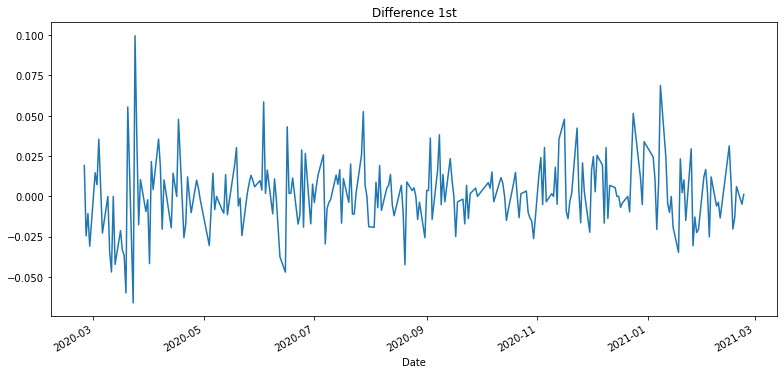

In [37]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [38]:
# ARIMA 모델 설계
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 537.526
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 23 Feb 2021   AIC                          -1069.052
Time:                        16:53:47   BIC                          -1058.844
Sample:                             1   HQIC                         -1064.930
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.397      0.162      -0.001       0.005
ar.L1.D.Close    -0.0215      0.067     -0.321      0.748      -0.153       0.110
                                    Root

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

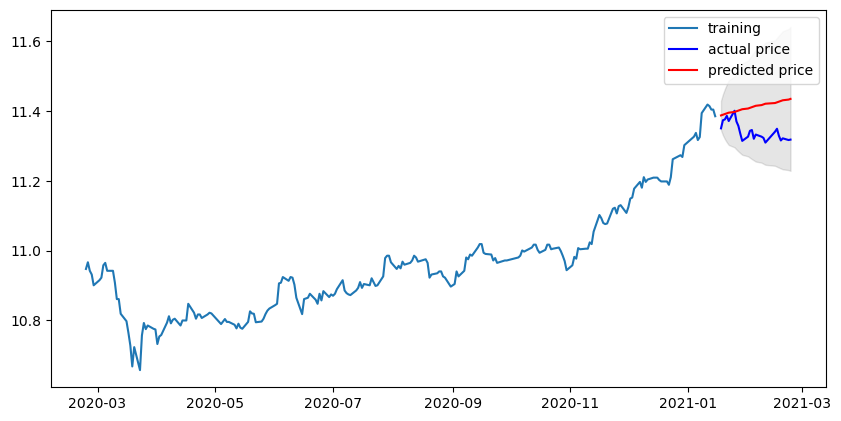

In [39]:
# 모델 예측
# Forecast : 결과가 fc에 담김
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [40]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46141846.024810955
MAE:  6028.034938311395
RMSE:  6792.778961869064
MAPE: 7.24%


- MAPE는 줄었으나 예상 가격과 실제 가격의 추세는 서로 차이가 있어보였다. 다만 이전에 전체 기간을 대상으로 했을 때 보다 실제로 절대적인 차이는 줄어들었다.

## SK 하이닉스

## STEP 1 : 시계열 데이터 준비

In [41]:
# data load
dataset_filepath = './data/000660.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,518700.0,555450.0,508200.0,540750.0,-240235.75000,441709.0
2000-01-05,507150.0,523950.0,477750.0,485100.0,-215512.50000,353061.0
2000-01-06,493500.0,499800.0,454650.0,459900.0,-204317.03125,310909.0
2000-01-07,445200.0,470400.0,436800.0,455700.0,-202451.09375,499628.0
2000-01-10,462000.0,468300.0,451500.0,451500.0,-200585.21875,382932.0


In [42]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    540750.0
2000-01-05    485100.0
2000-01-06    459900.0
2000-01-07    455700.0
2000-01-10    451500.0
Name: Close, dtype: float64

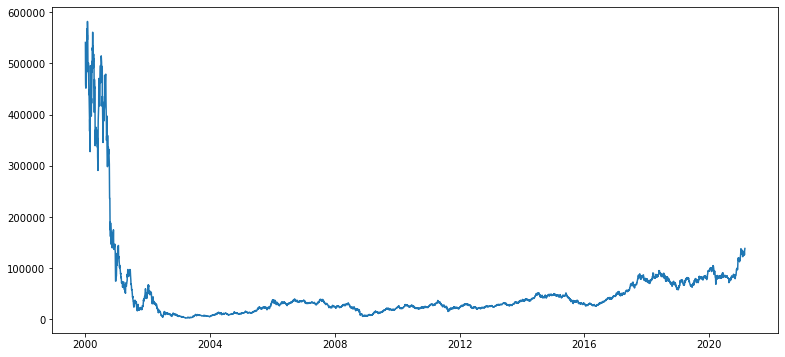

In [43]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

## STEP 2 : 각종 전처리 수행

In [44]:
# 결측치 확인
ts[ts.isna()]

Date
2005-01-03   NaN
2008-05-01   NaN
2008-05-05   NaN
2008-05-12   NaN
2008-06-06   NaN
2008-08-15   NaN
2008-09-15   NaN
2008-10-03   NaN
2008-12-25   NaN
2008-12-31   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [45]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


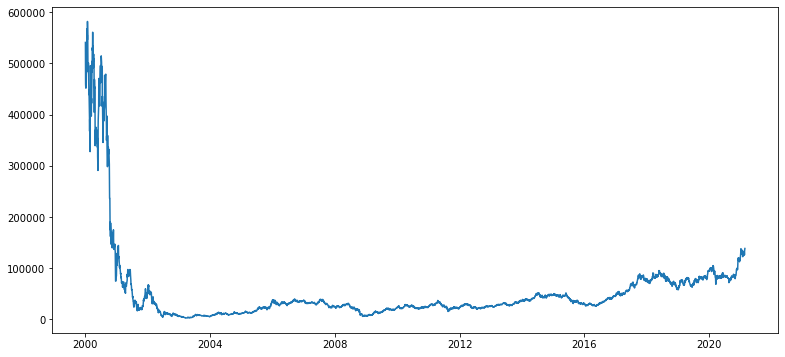

In [46]:
plt.plot(ts)

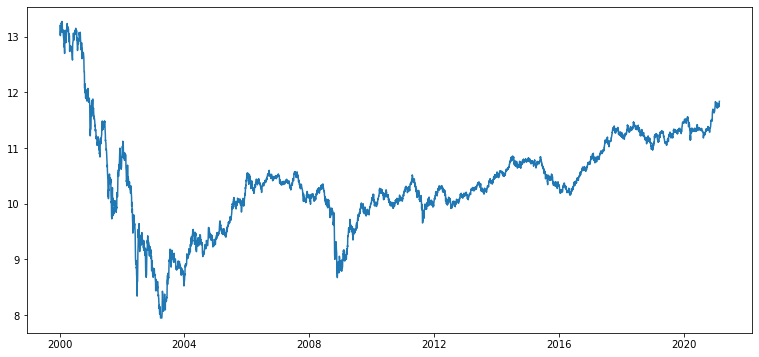

In [47]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [48]:
# adfuller method를 이용하여 Augmented Dickey-Fuller Test 수행
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [49]:
# 일정 구간 내 통계치(Rolling Statistics)를 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

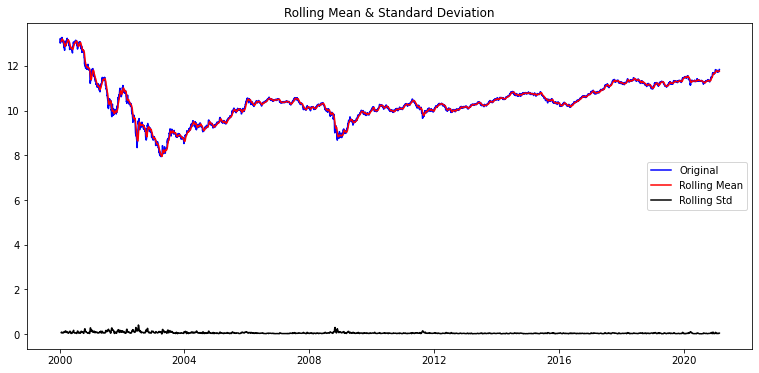

In [50]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [51]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -2.692379
p-value                           0.075366
#Lags Used                        9.000000
Number of Observations Used    5305.000000
Critical Value (1%)              -3.431583
Critical Value (5%)              -2.862085
Critical Value (10%)             -2.567060
dtype: float64


- p-value가 0.05 이상이므로 Stationary하지 않은 데이터라고 할 수 있다.

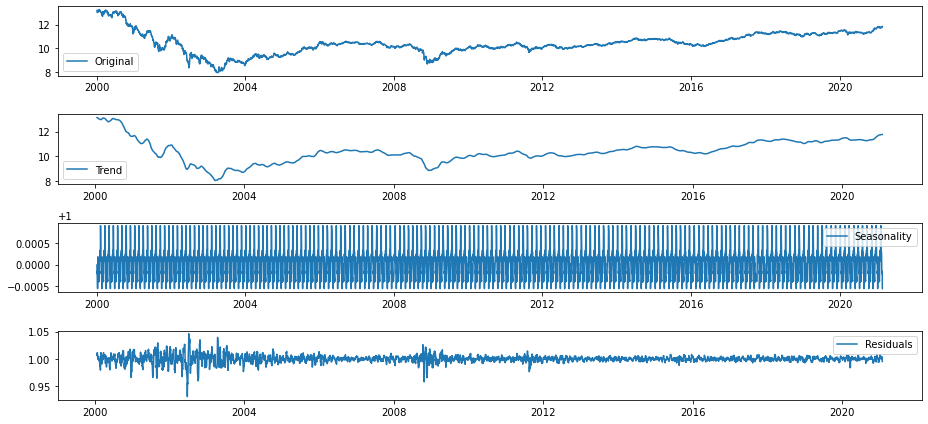

In [52]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [53]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -19.002477
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    5254.000000
Critical Value (1%)              -3.431595
Critical Value (5%)              -2.862090
Critical Value (10%)             -2.567063
dtype: float64


## STEP 4 : train, test dataset 생성

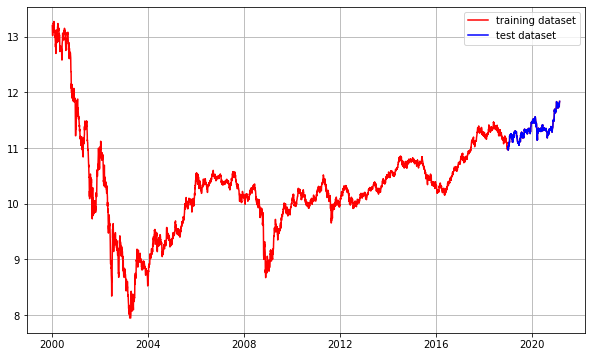

In [54]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

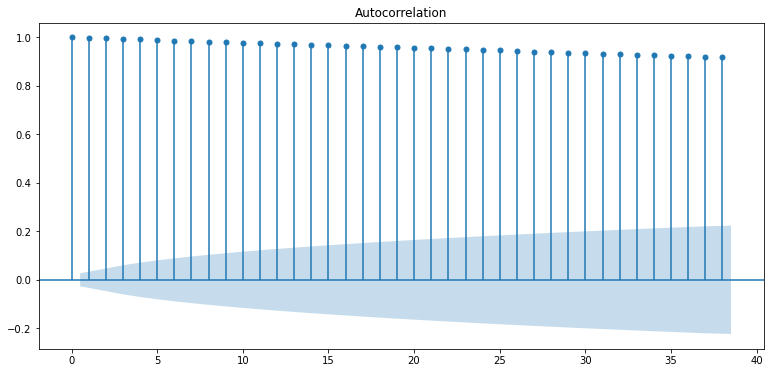

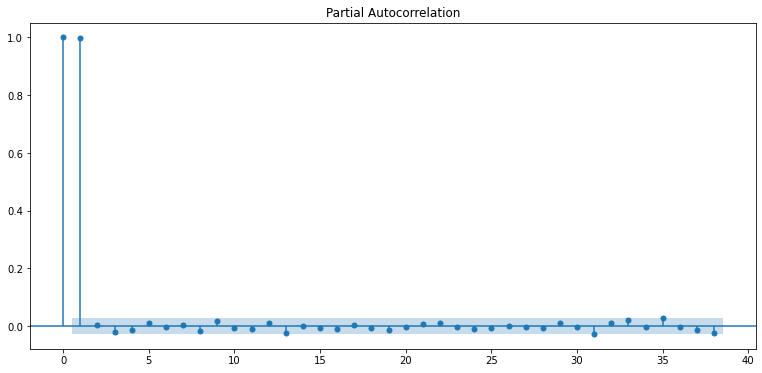

In [55]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -24.814103
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    5305.000000
Critical Value (1%)              -3.431583
Critical Value (5%)              -2.862085
Critical Value (10%)             -2.567060
dtype: float64


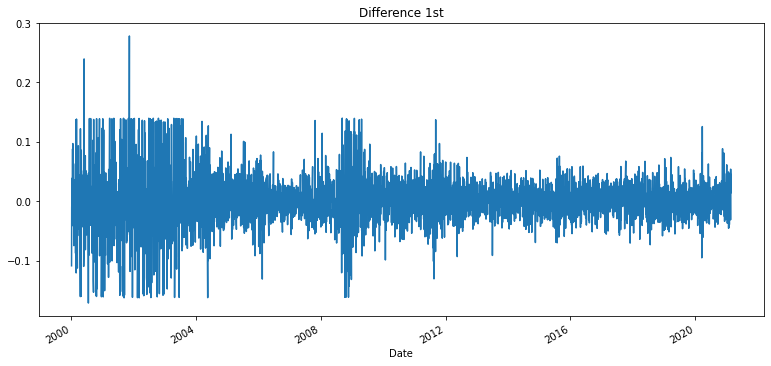

In [56]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [57]:
# ARIMA 모델 설계
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4782
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8557.787
Method:                       css-mle   S.D. of innovations              0.040
Date:                Tue, 23 Feb 2021   AIC                         -17109.574
Time:                        16:53:49   BIC                         -17090.157
Sample:                             1   HQIC                        -17102.753
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0005      0.001     -0.759      0.448      -0.002       0.001
ar.L1.D.Close     0.0340      0.014      2.349      0.019       0.006       0.062
                                    Root

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

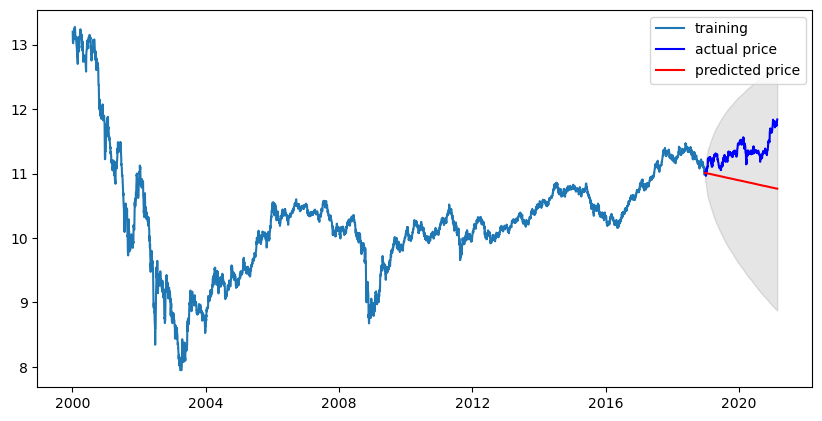

In [58]:
# 모델 예측
# Forecast : 결과가 fc에 담김
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [59]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1372450136.7735367
MAE:  31806.324581053745
RMSE:  37046.59413189742
MAPE: 34.80%


- SK 하이닉스의 경우 과거의 주가와 현재의 주가의 사이에서 규칙적인 경향성을 찾기 어렵다고 판단하여 기간을 조금 줄여보았다.
- 과거의 주가가 비정상적으로 높은 경향을 보여서 잘못된 데이터인줄 알았는데 진짜였다... 도대체 무슨 일이 있었던 것인가..

## STEP 1 : 시계열 데이터 준비

In [60]:
# data load
dataset_filepath = './data/000660.KS_1years.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-24,100500.0,100500.0,98900.0,99500.0,98492.078125,5550758
2020-02-25,97800.0,99100.0,96400.0,98000.0,97007.273438,6594059
2020-02-26,95500.0,96100.0,94400.0,94600.0,93641.710938,6405409
2020-02-27,94700.0,95300.0,92200.0,92800.0,91859.945313,4644449
2020-02-28,91000.0,92200.0,87700.0,87900.0,87009.585938,8171939


In [61]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-02-24    99500.0
2020-02-25    98000.0
2020-02-26    94600.0
2020-02-27    92800.0
2020-02-28    87900.0
Name: Close, dtype: float64

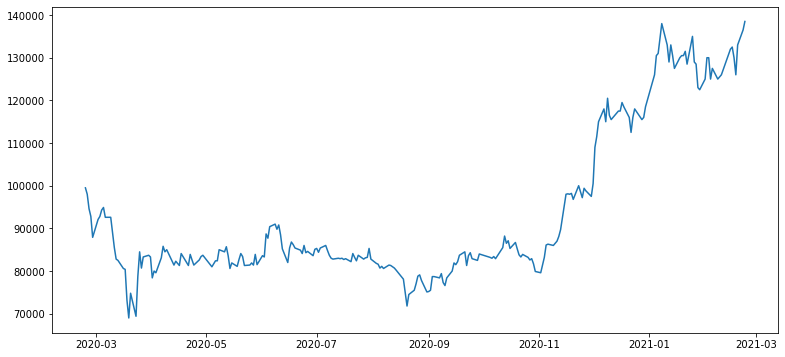

In [62]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

## STEP 2 : 각종 전처리 수행

In [63]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [64]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


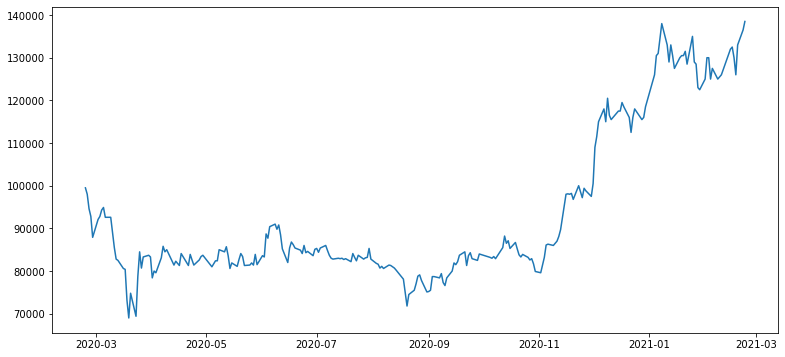

In [65]:
plt.plot(ts)

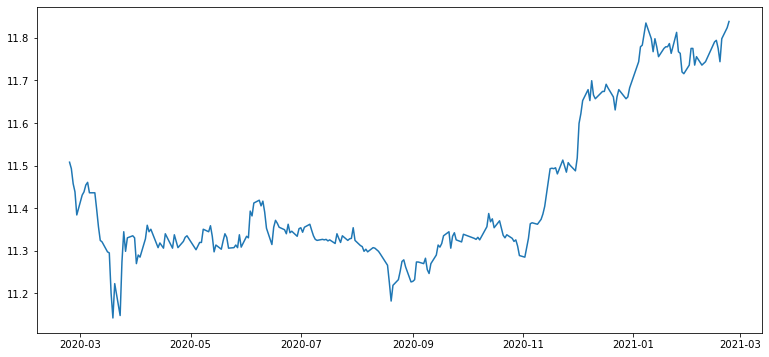

In [66]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [67]:
# adfuller method를 이용하여 Augmented Dickey-Fuller Test 수행
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [68]:
# 일정 구간 내 통계치(Rolling Statistics)를 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

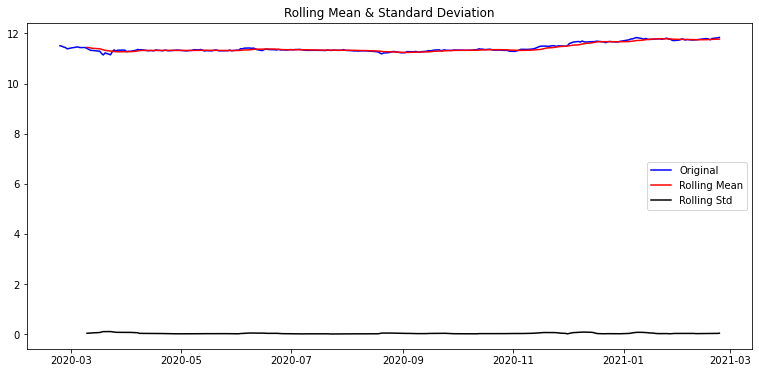

In [69]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [70]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.102533
p-value                          0.949186
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- p-value가 0.05 이상이므로 Stationary하지 않은 데이터라고 할 수 있다.

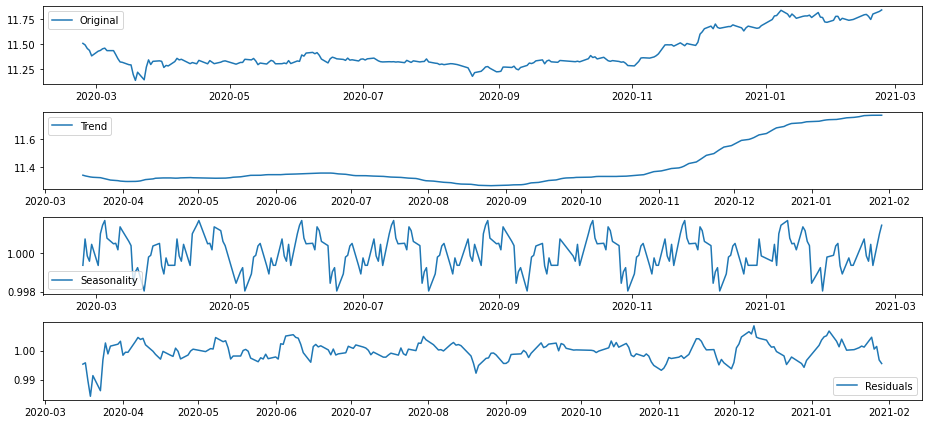

In [71]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [72]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.983680e+00
p-value                        1.813305e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


## STEP 4 : train, test dataset 생성

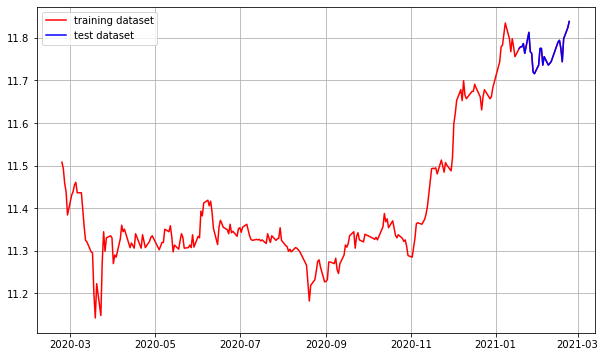

In [73]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

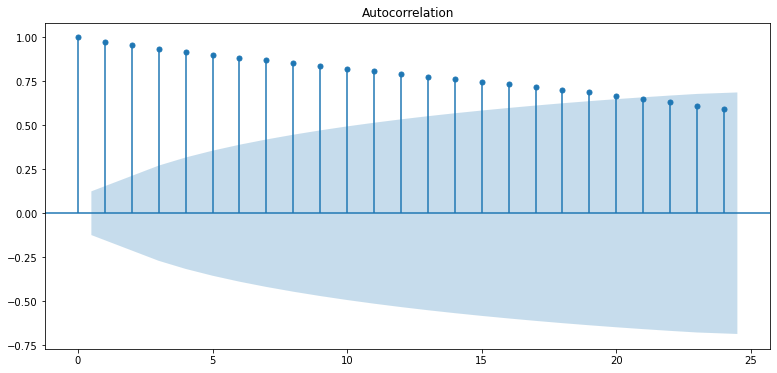

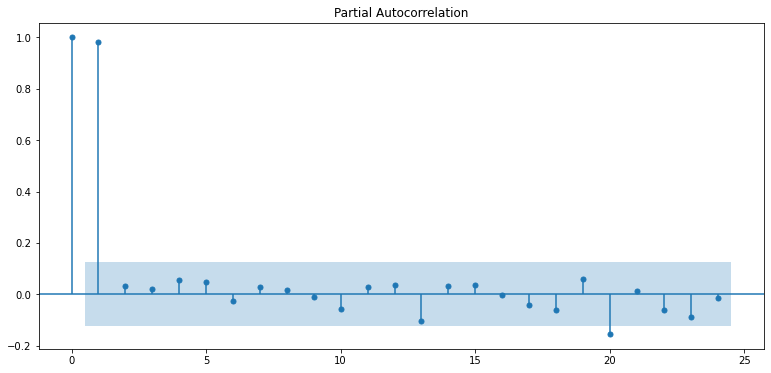

In [74]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.897970e+00
p-value                        1.192587e-14
#Lags Used                     3.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


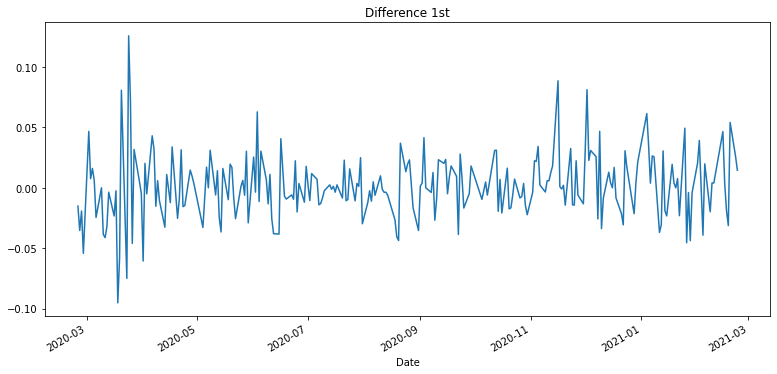

In [75]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [76]:
# ARIMA 모델 설계
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 487.917
Method:                       css-mle   S.D. of innovations              0.027
Date:                Tue, 23 Feb 2021   AIC                           -969.835
Time:                        16:53:51   BIC                           -959.627
Sample:                             1   HQIC                          -965.714
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.002      0.637      0.524      -0.002       0.005
ar.L1.D.Close    -0.0250      0.067     -0.373      0.710      -0.157       0.107
                                    Root

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

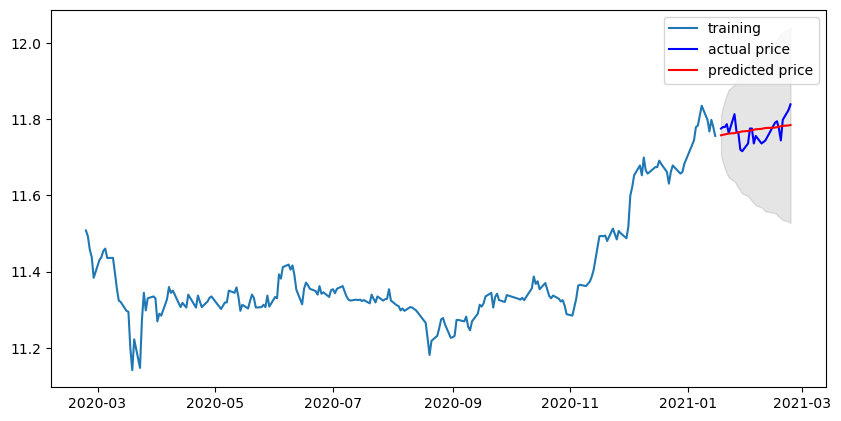

In [77]:
# 모델 예측
# Forecast : 결과가 fc에 담김
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [78]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14925923.146525223
MAE:  3212.4717921854904
RMSE:  3863.4082293391184
MAPE: 2.49%


- SK 하이닉스의 1년치 주가에 대한 예측은 예측 가격과 실제 가격의 추세도 일치하고 2.49%의 낮은 오차율을 보여줬다!

## 맥쿼리인프라

## STEP 1 : 시계열 데이터 준비

In [79]:
# data load
dataset_filepath = './data/088980.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-03-15,7100.0,7890.0,7090.0,7410.0,4635.760254,4392952.0
2006-03-16,7490.0,7550.0,7250.0,7440.0,4654.528320,1864770.0
2006-03-17,7400.0,7530.0,7370.0,7430.0,4648.272461,940080.0
2006-03-20,7400.0,7470.0,7400.0,7400.0,4629.504883,566740.0
2006-03-21,7400.0,7440.0,7390.0,7400.0,4629.504883,556248.0


In [80]:
# 종가(close) 데이터만 사용
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2006-03-15    7410.0
2006-03-16    7440.0
2006-03-17    7430.0
2006-03-20    7400.0
2006-03-21    7400.0
Name: Close, dtype: float64

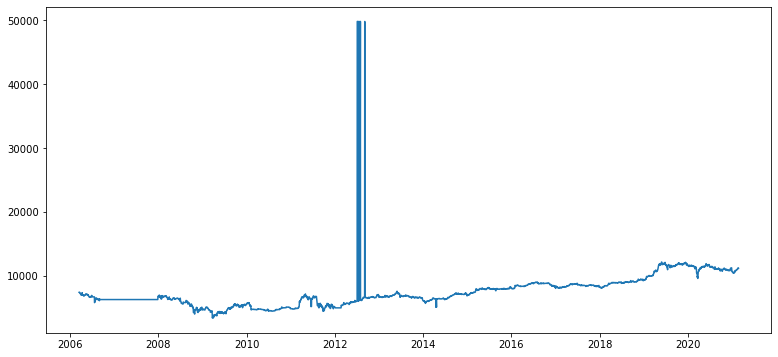

In [81]:
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

## STEP 2 : 각종 전처리 수행

In [82]:
# 결측치 확인
ts[ts.isna()]

Date
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [83]:
# 결측치 보간
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


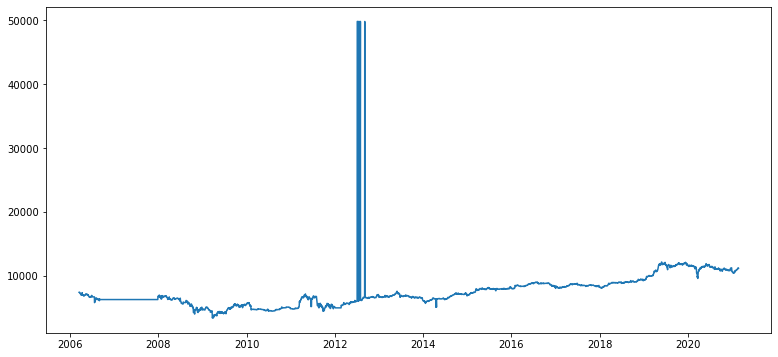

In [84]:
plt.plot(ts)

### 이상치 제거

In [94]:
ts.loc[ts > 20000]

Date
2012-07-04    49790.648438
2012-07-05    49790.648438
2012-07-06    49790.648438
2012-07-09    49790.648438
2012-07-16    49790.648438
2012-07-25    49790.648438
2012-07-30    49790.648438
2012-09-04    49790.648438
Name: Close, dtype: float64

In [98]:
ts['2012-07-04'] = 5205.0
ts['2012-07-05'] = 5156.0
ts['2012-07-06'] = 5172.0
ts['2012-07-09'] = 5230.0
ts['2012-07-16'] = 5156.0
ts['2012-07-25'] = 5223.0
ts['2012-07-30'] = 5180.0
ts['2012-09-04'] = 5540.0

In [99]:
ts.loc[ts > 20000]

Series([], Name: Close, dtype: float64)

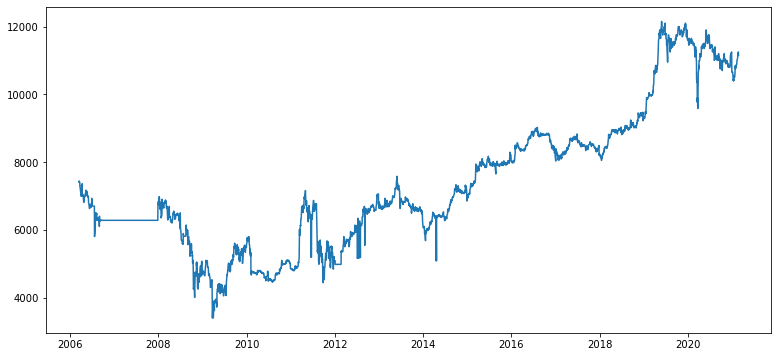

In [101]:
plt.plot(ts)

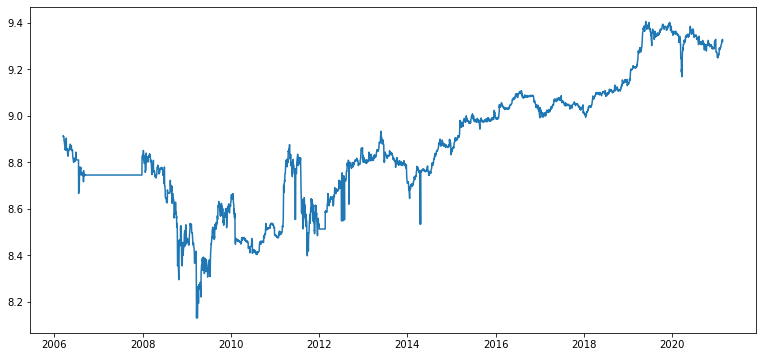

In [102]:
# log scale로 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [103]:
# adfuller method를 이용하여 Augmented Dickey-Fuller Test 수행
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [104]:
# 일정 구간 내 통계치(Rolling Statistics)를 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

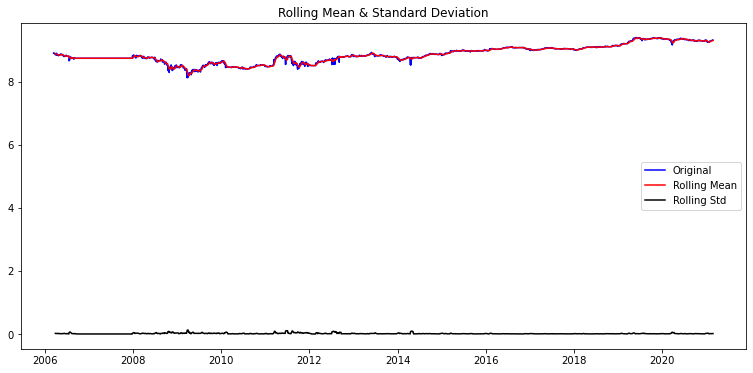

In [105]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [106]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.690199
p-value                           0.849272
#Lags Used                       14.000000
Number of Observations Used    3687.000000
Critical Value (1%)              -3.432125
Critical Value (5%)              -2.862324
Critical Value (10%)             -2.567187
dtype: float64


- p-value가 0.05 이상이므로 Stationary하지 않은 데이터라고 할 수 있다.

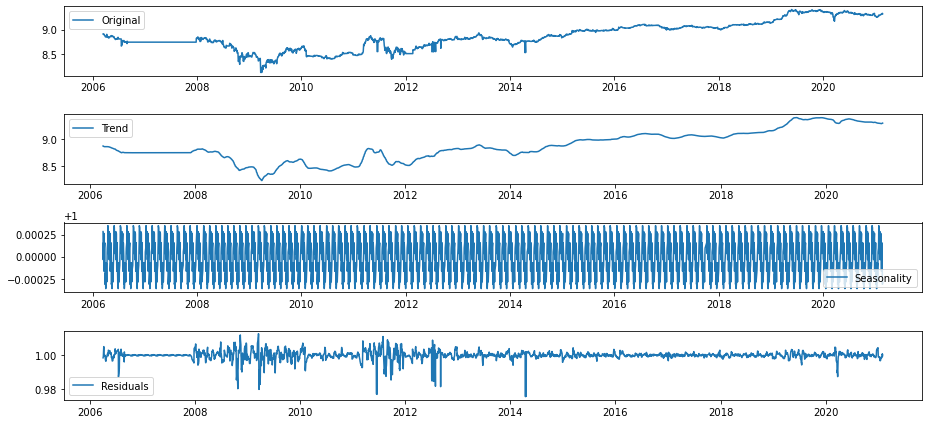

In [107]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [108]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.591215e+01
p-value                        8.100702e-29
#Lags Used                     2.800000e+01
Number of Observations Used    3.643000e+03
Critical Value (1%)           -3.432146e+00
Critical Value (5%)           -2.862334e+00
Critical Value (10%)          -2.567193e+00
dtype: float64


## STEP 4 : train, test dataset 생성

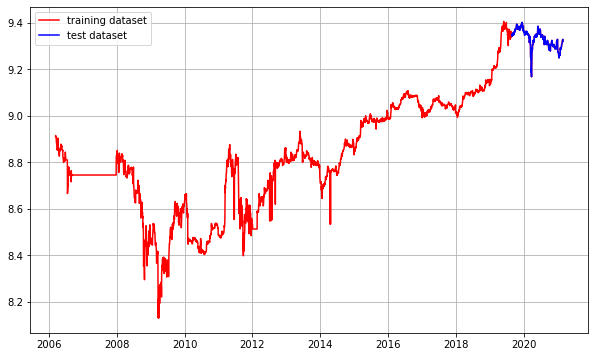

In [109]:
# train, test 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

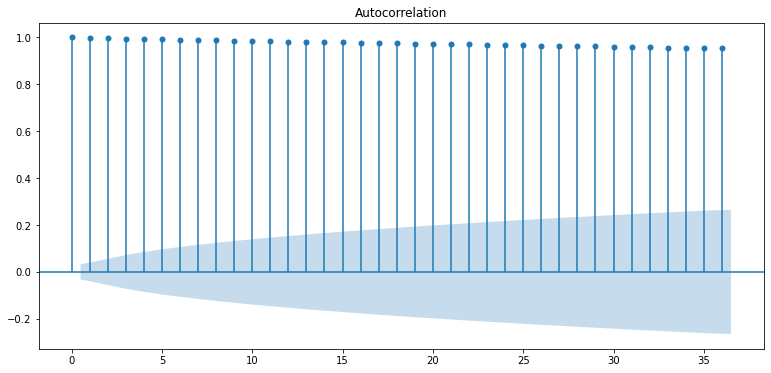

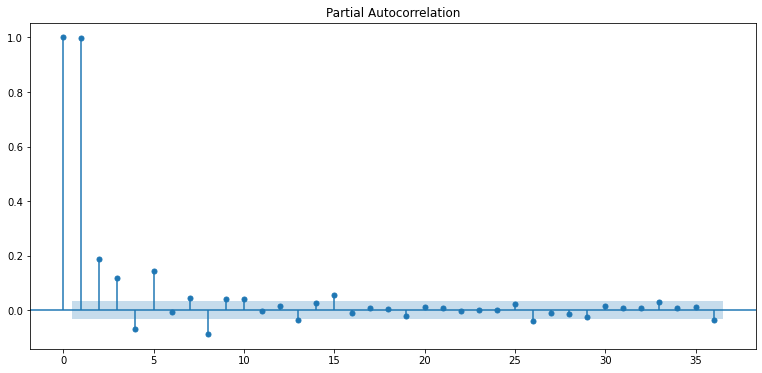

In [110]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.831487e+01
p-value                        2.272108e-30
#Lags Used                     1.300000e+01
Number of Observations Used    3.687000e+03
Critical Value (1%)           -3.432125e+00
Critical Value (5%)           -2.862324e+00
Critical Value (10%)          -2.567187e+00
dtype: float64


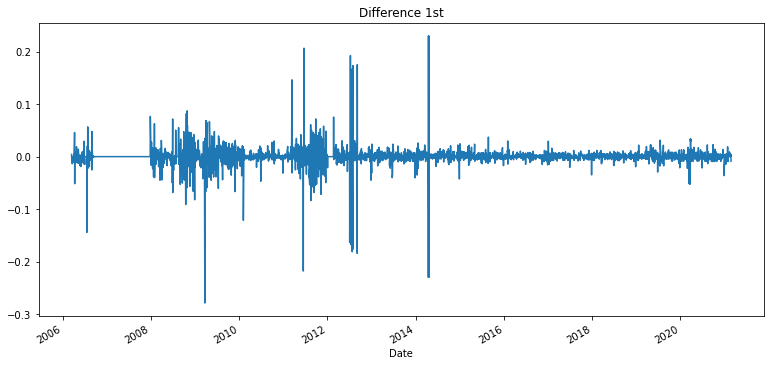

In [111]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [127]:
# ARIMA 모델 설계
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3330
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8523.298
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 23 Feb 2021   AIC                         -17040.596
Time:                        17:43:35   BIC                         -17022.264
Sample:                             1   HQIC                        -17034.037
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.000      0.485      0.628      -0.000       0.001
ar.L1.D.Close    -0.2072      0.017    -12.225      0.000      -0.240      -0.174
                                    Root

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

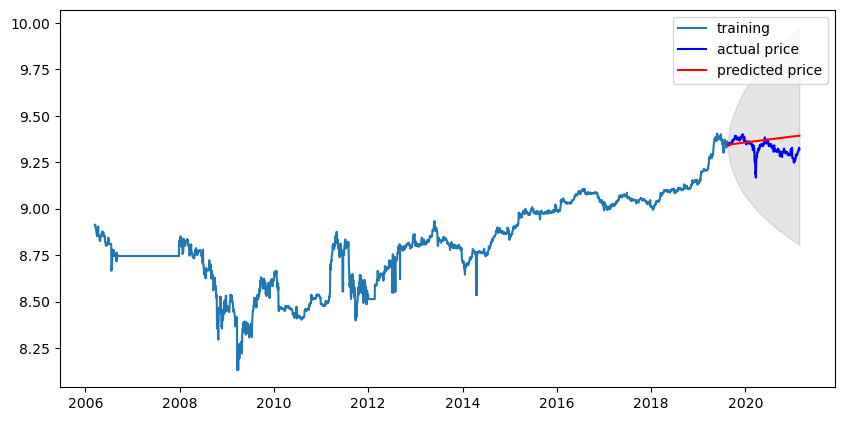

In [128]:
# 모델 예측
# Forecast : 결과가 fc에 담김
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [129]:
# 모델 예측 정확도 측정
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  493682.800094525
MAE:  559.2527674192742
RMSE:  702.6256471938133
MAPE: 5.09%


- 맥쿼리인프라의 경우 2012년도 7월, 9월에 이상치가 있어서 확인해본 결과 야후 파이낸스의 데이터가 잘못되었음을 확인하고 네이버 증권의 데이터로 대체하였다.
- 맥쿼리인프라의 경우 주어진 기간동안 주가가 크게 변동하지 않아서 그런지 전체 데이터로도 충분히 낮은 오차를 보여줬다.

## 회고록

- 시계열 데이터를 처음 접했을 땐 다루기 어려운 데이터라고 생각했는데 노드를 진행하면서 계속 다루다보니 조금은 익숙해진 것 같다.
- 예전부터 주가를 예측하는 것은 한번 해보고 싶었는데 생각보다 어려운 것 같다. 하긴 쉬우면 누구나 부자가 됐겠지...
- 처음으로 raw data를 처리하는 과정에서 이상치를 발견하여 그동안 학습한 방법을 동원하여 정상적으로 수정하였다! 직접 해보고 나니 조금은 성장했다고 느꼈다.
- 이전에 해커톤을 진행했을 때도 시계열 데이터를 가지고 가격을 예측하는 문제에서 ARIMA 모델은 성능이 별로여서 XGBoost와 LightGBM을 이용했던 기억이 난다. 이 모델도 추후 앙상블 모델을 이용해서 한번 예측을 시도해봐야겠다.